In [1]:
import pandas as pd
import numpy as np

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

In [73]:
data = pd.read_csv('kickstarter.csv', parse_dates=['launched'])

In [3]:
data = data.assign(outcome=(data.state == 'successful').astype(int))
data.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0


In [4]:
data.shape

(378661, 16)

In [5]:
data = data.query("state != 'live'")
data.shape

(375862, 16)

In [6]:
data = data.assign(hour=data.launched.dt.hour,
                  day=data.launched.dt.day,
                  month=data.launched.dt.month,
                  year=data.launched.dt.year)
data.shape

(375862, 20)

In [7]:
cat_features = ['category', 'currency', 'country']

In [8]:
encoder = ce.CountEncoder(cols=cat_features)

In [9]:
num_X = data[['hour', 'day', 'month', 'year', 'goal', 'outcome']]
num_X.head()

,hour,day,month,year,goal,outcome
0,12,11,8,2015,1000.0,0
1,4,2,9,2017,30000.0,0
2,0,12,1,2013,45000.0,0
3,3,17,3,2012,5000.0,0
4,8,4,7,2015,19500.0,0


In [10]:
X = num_X.join(data[cat_features])

X.head()

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US
3,3,17,3,2012,5000.0,0,Music,USD,US
4,8,4,7,2015,19500.0,0,Film & Video,USD,US


In [11]:
valid_fraction = 0.1
valid_size = int(len(X) * valid_fraction)

train = X[: -2* valid_size]
valid = X[-2*valid_size: -valid_size]
test = X[-valid_size:]
test.shape

(37586, 9)

In [12]:
train.head(2)

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US


In [13]:
encoder.fit(train[cat_features])

CountEncoder(cols=['category', 'currency', 'country'],
             combine_min_nan_groups=True, drop_invariant=False,
             handle_missing='count', handle_unknown=None, min_group_name=None,
             min_group_size=None, normalize=False, return_df=True, verbose=0)

In [14]:
count_train = train.join(encoder.transform(train[cat_features]).add_suffix('_count'))
count_valid = valid.join(encoder.transform(valid[cat_features]).add_suffix('_count'))
count_test = test.join(encoder.transform(test[cat_features]).add_suffix('_count'))

count_train.head()

,hour,day,month,year,goal,outcome,category,currency,country,category_count,currency_count,country_count
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,1055,27142,26770
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,4160,234783,232607
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,4160,234783,232607
3,3,17,3,2012,5000.0,0,Music,USD,US,12485,234783,232607
4,8,4,7,2015,19500.0,0,Film & Video,USD,US,8076,234783,232607


In [15]:
param = {'num_leaves': 65, 'objective': 'binary', 'metrics': 'auc'}
num_rounds = 1000

In [16]:
features = count_train.columns.drop(['outcome', 'category', 'currency', 'country'])
features

Index(['hour', 'day', 'month', 'year', 'goal', 'category_count',
       'currency_count', 'country_count'],
      dtype='object')

In [17]:
dtrain = lgb.Dataset(count_train[features], train['outcome'])
dvalid = lgb.Dataset(count_valid[features], valid['outcome'])

In [18]:
model = lgb.train(param, dtrain, num_rounds, valid_sets=[dvalid], early_stopping_rounds=5)

[LightGBM] [Info] Number of positive: 107340, number of negative: 193350
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 300690, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356979 -> initscore=-0.588501
[LightGBM] [Info] Start training from score -0.588501
[1]	valid_0's auc: 0.693797
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696566
[3]	valid_0's auc: 0.703284
[4]	valid_0's auc: 0.706447
[5]	valid_0's auc: 0.708446
[6]	valid_0's auc: 0.709716
[7]	valid_0's auc: 0.710423
[8]	valid_0's auc: 0.711094
[9]	valid_0's auc: 0.712814
[10]	valid_0's auc: 0.713492
[11]	valid_0's auc: 0.714588
[12]	valid_0's auc: 0.715286
[13]	valid_0's auc: 0.716922
[14]	valid

In [19]:
preds = model.predict(count_test[features])
score = metrics.roc_auc_score(count_test['outcome'], preds)
score

0.7470107880058254

# Some FeAturE eNGineeRing

### INterActions

In [20]:
new_X = X.copy()
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US


In [21]:
new_X.shape

(375862, 9)

In [22]:
new_X['country_categ'] = new_X.country + '_' + new_X.category
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,GB_Poetry
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,US_Narrative Film
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,US_Narrative Film


In [23]:
new_X = new_X.assign(category_curren=(new_X.category + '_' + new_X.currency))
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,GB_Poetry,Poetry_GBP
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD


# Number of Projects in last week

### Time Series and Rolling Window Def

In [75]:
data[['launched']].head(3)

,launched
0,2015-08-11 12:12:28
1,2017-09-02 04:43:57
2,2013-01-12 00:20:50


In [77]:
data[['launched', 'category']].dtypes

launched    datetime64[ns]
category            object
dtype: object

In [78]:
# Create series with Timestamp index
launched = pd.Series(data.index, index=data.launched, name='count_7_days').sort_index()
launched.head(10)

# Series contains the index values
# To be return later

launched
1970-01-01 01:00:00     75397
1970-01-01 01:00:00    319002
1970-01-01 01:00:00      2842
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    247913
1970-01-01 01:00:00    273779
1970-01-01 01:00:00     48147
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
Name: count_7_days, dtype: int64

In [79]:
# With the TImestamp index
# Use .Rolling def to select time periods
count_7_days = launched.rolling('7d').count() - 1

# The first 7 rows have incorrect data
count_7_days[7:].head(10)

launched
2009-04-21 21:02:48    0.0
2009-04-23 00:07:53    1.0
2009-04-24 21:52:03    2.0
2009-04-25 17:36:21    3.0
2009-04-27 14:10:39    4.0
2009-04-28 13:55:41    5.0
2009-04-29 02:04:21    5.0
2009-04-29 02:58:50    6.0
2009-04-29 04:37:37    7.0
2009-04-29 05:26:32    8.0
Name: count_7_days, dtype: float64

In [65]:
# Plot the days
import matplotlib.pyplot as plt

%matplotlib inline

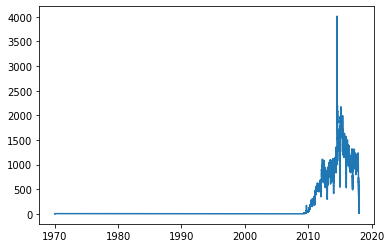

In [67]:
plt.plot(count_7_days)

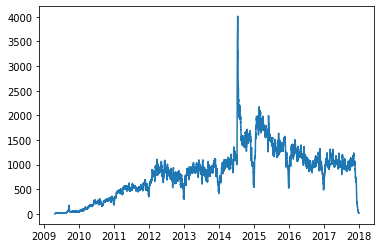

In [68]:
# As you can see
# Remove the first 7 entries
plt.plot(count_7_days[7:])

In [70]:
# REturn the index of the original dataframe 
# Join to other features
count_7_days.index = launched.values
count_7_days.head()

# Now the indices are all joumbled up
# use .reindex def

94579     0.0
319002    1.0
247913    2.0
48147     3.0
75397     4.0
Name: count_7_days, dtype: float64

In [71]:
count_7_days = count_7_days.reindex(data.index)
count_7_days.head()

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
Name: count_7_days, dtype: float64

In [82]:
print(count_7_days.min())
print(count_7_days.max())
print(count_7_days.mean())
print(count_7_days.std())

0.0
4012.0
1121.4184613678199
478.88911737679524


In [74]:
df = data[['category', 'launched']]

df.head()

,category,launched
0,Poetry,2015-08-11 12:12:28
1,Narrative Film,2017-09-02 04:43:57
2,Narrative Film,2013-01-12 00:20:50
3,Music,2012-03-17 03:24:11
4,Film & Video,2015-07-04 08:35:03


In [24]:
cat_cols = [col for col in new_X.columns if new_X[col].dtype == 'object']
cat_cols

['category', 'currency', 'country', 'country_categ', 'category_curren']

In [25]:
num_sub = new_X.drop(cat_cols, axis=1)
num_sub.head(2)

,hour,day,month,year,goal,outcome
0,12,11,8,2015,1000.0,0
1,4,2,9,2017,30000.0,0


In [26]:
valid_fraction = 0.1
valid_size = int(len(new_X) * valid_fraction)

train = new_X[: -2* valid_size]
valid = new_X[-2*valid_size: -valid_size]
test = new_X[-valid_size:]
test.head(2)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren
340783,14,27,10,2014,3000.0,1,Calendars,USD,US,US_Calendars,Calendars_USD
340784,18,19,8,2015,2500.0,0,Rock,USD,US,US_Rock,Rock_USD


In [27]:
my_enc = ce.CountEncoder(cols=cat_cols)
my_enc.fit(train[cat_cols])

CountEncoder(cols=['category', 'currency', 'country', 'country_categ',
                   'category_curren'],
             combine_min_nan_groups=True, drop_invariant=False,
             handle_missing='count', handle_unknown=None, min_group_name=None,
             min_group_size=None, normalize=False, return_df=True, verbose=0)

In [44]:
train_2 = train.join(my_enc.transform(train[cat_cols]).add_suffix('_count'))
valid_2 = valid.join(my_enc.transform(valid[cat_cols]).add_suffix('_count'))
test_2 = test.join(my_enc.transform(test[cat_cols]).add_suffix('_count'))

test_2.head()

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren,category_count,currency_count,country_count,country_categ_count,category_curren_count
340783,14,27,10,2014,3000.0,1,Calendars,USD,US,US_Calendars,Calendars_USD,235,234783,232607,162.0,162.0
340784,18,19,8,2015,2500.0,0,Rock,USD,US,US_Rock,Rock_USD,5360,234783,232607,4835.0,4835.0
340785,19,29,9,2015,750.0,1,Playing Cards,GBP,GB,GB_Playing Cards,Playing Cards_GBP,1974,27142,26770,184.0,184.0
340786,18,23,10,2016,15000.0,0,Musical,USD,US,US_Musical,Musical_USD,725,234783,232607,504.0,504.0
340787,3,8,3,2017,2000.0,1,Technology,CAD,CA,CA_Technology,Technology_CAD,5512,11911,11737,355.0,355.0


In [35]:
test_2.head(2)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren,category_count,currency_count,country_count,country_categ_count,category_curren_count
340783,14,27,10,2014,3000.0,1,Calendars,USD,US,US_Calendars,Calendars_USD,235,234783,232607,162.0,162.0
340784,18,19,8,2015,2500.0,0,Rock,USD,US,US_Rock,Rock_USD,5360,234783,232607,4835.0,4835.0


In [29]:
features = train_2.columns.drop(['outcome', 'category', 'currency', 'country', 'country_categ', 'category_curren'])
features

Index(['hour', 'day', 'month', 'year', 'goal', 'category_count',
       'currency_count', 'country_count', 'country_categ_count',
       'category_curren_count'],
      dtype='object')

In [30]:
dtrain = lgb.Dataset(train_2[features], train_2['outcome'])
dvalid = lgb.Dataset(valid_2[features], valid_2['outcome'])
dtrain

In [31]:
param = {'num_leaves': 65, 'objective': 'binary', 'metrics': 'auc'}
num_rounds = 1000

In [42]:
model_2 = lgb.train(param, dtrain, num_rounds, valid_sets=[dvalid], early_stopping_rounds=5, verbose_eval=False)

print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print(f"Best valid score: {model_2.best_score}")

[LightGBM] [Info] Number of positive: 107340, number of negative: 193350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 300690, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356979 -> initscore=-0.588501
[LightGBM] [Info] Start training from score -0.588501
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Best valid score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7463650082553166)])})


In [33]:
preds_2 = model_2.predict(test_2[features])
preds_2

array([0.46384117, 0.51083014, 0.41097405, ..., 0.36342515, 0.22722291,
       0.58696262])

In [43]:
score_2 = metrics.roc_auc_score(test_2['outcome'], preds_2)
print('The Test Score:')
score_2

The Test Score:


0.7459727149439198